**URL:**

https://global.kawasaki.com/en/corp/newsroom/news/index.html

In [1]:
#libraries
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random,textstat,urllib.request
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

Autosaving every 1 seconds


In [2]:
#site name , domain and site link
SITE_NAME='Kawasaki'

DOMAIN = "https://global.kawasaki.com"

SITE_LINK = "https://global.kawasaki.com/en/corp/newsroom/news/index.html"

In [3]:
#functions
def parse_webpage_bs(search_url):
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0"}
    try:
        site_request = requests.get(search_url, headers=headers, timeout=10)
    except requests.exceptions.RequestException as e:
        print(e)
        site_request = None
    if site_request != None and site_request.status_code==200:
        site_soup = bs4.BeautifulSoup(site_request.content, "lxml")
    else:
        site_soup = None
    return site_soup

def remove_esc_chars(string):
    review = re.sub('''[^a-zA-Z0-9!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~°]''', ' ',string)
    review = review.split()
    review = ' '.join(review)
    return review

def get_text_thumb(link): 
    try:
        soup = parse_webpage_bs(link)
        text_n_thumb = soup.find('div', {'class': 'row block'})
        thumbnails = text_n_thumb.find_all('div', {'align': 'center'})
        all_thumbnails = []
        for th in thumbnails:
            try:
                all_thumbnails.append(DOMAIN + th.find("img")["src"])
            except:
                pass
        thumb = all_thumbnails[0]
        ps = text_n_thumb.text
        text = remove_esc_chars(ps).strip()
    except:
        thumb = "https://global.kawasaki.com/common/img/identity.png"
        g = Goose()
        article_extract = g.extract(url=link)
        article = remove_esc_chars(article_extract.cleaned_text)
        meta_data = remove_esc_chars(article_extract.meta_description)
        whole_data = meta_data+article
        text = whole_data.strip()

        if textstat.lexicon_count(text, removepunct=True) < 5:
            try:
                response = requests.get(link)
                text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

                if textstat.lexicon_count(text, removepunct=True) < 5:
                    texts = ""
                    r = requests.get(link)
                    filename = Path('temp.pdf')
                    filename.write_bytes(r.content)

                    pages = convert_from_path('temp.pdf', 500)
                    for x in pages:
                        x.save("temp.jpg")
                        output = reader.readtext("temp.jpg")
                        for o in output:
                            texts += o[1]

                    text = remove_esc_chars(texts)

                    if textstat.lexicon_count(text, removepunct=True) < 5:
                        texts = ""
                        soup = parse_webpage_bs(link)
                        if soup!= None:
                            ps = soup.findAll('p')
                            for p in ps:
                                texts+= p.text

                        text = remove_esc_chars(texts)
            except:
                text = ""
    
    return text , thumb

In [4]:
#get data
article_list = []

pagination = datetime.today().year
last_page = 2001

while pagination >= last_page:
    try:
        #getting soup fom url 
        url = f"https://global.kawasaki.com/en/corp/newsroom/news/index.html?year={pagination}&category="
        soup = parse_webpage_bs(url)

        #container
        container = soup.findAll('dl', {'class': 'line_1ofList'})

        #creating empty lists to append data 
        published_dates,titles,texts,links,thumbnails,authors = [],[],[],[],[],[]

        for element in tqdm(container[:10],desc=f"Getting Data for year {pagination}"):
            published_date  = element.find('dt').text.strip()
            published_dates.append(published_date)
            title_n_link = element.find('dd')
            title  = remove_esc_chars(title_n_link.text.strip())
            titles.append(title)
            link_fetched = title_n_link.find('a')['href']
            if not re.findall("http",link_fetched):
                link =  DOMAIN +  title_n_link.find('a')['href']
            else:
                link = link_fetched
            links.append(link)
            author = SITE_NAME
            authors.append(author)
            text,thumbnail = get_text_thumb(link)
            texts.append(text)
            thumbnails.append(thumbnail)

        #zippig all the data togather 
        zipped = list(zip(published_dates,titles,texts,links,thumbnails,authors))

        #unwinding and appending to the main list
        for published_date,title,text,link,thumbnail,author in zipped:
            article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
            article_list.append(article)
            print(published_date,title)

        #my condition to break
        if pagination == 2021:
            break
            
        pagination -=1 
    except:
        print("retrying...")

Getting Data for year 2022:   0%|          | 0/10 [00:00<?, ?it/s]

Jun. 29, 2022 LPG-fueled LPG carrier CRYSTAL OASIS Delivered
Jun. 24, 2022 RESOLUTIONS OF THE 199th ORDINARY GENERAL MEETING OF SHAREHOLDERS(2022)
Jun. 23, 2022 Bulk Carrier PHILHOKUSAI Delivered
Jun. 21, 2022 Kawasaki Receives an Order for an 86,700 m LPG-fueled LPG/ NH3 Carrier
Jun. 17, 2022 Bulk Carrier AQUARUBY Delivered
Jun. 16, 2022 WMATA 7000 Series Railcars to Resume Service Operation (PDF:47.4K )
Jun. 07, 2022 Notice of Inappropriate Conduct by Kawasaki Thermal Engineering Co., Ltd.
Jun. 06, 2022 Kawasaki decides to issue Green Bond Contribution to global carbon neutrality by building a clean h...
May 31, 2022 Kawasaki Completes World s First Basic Engineering Works for Hydrogen Marine Main Boiler
May 26, 2022 THE 199th ORDINARY GENERAL MEETING OF SHAREHOLDERS (2022)


Getting Data for year 2021:   0%|          | 0/10 [00:00<?, ?it/s]

Dec. 27, 2021 Kawasaki Receives First Order from Malaysia for Cogeneration System Using Fully Made-in-Japan M5A Ga...
Dec. 21, 2021 Total Sales of PV Series Hydraulic Remote Control Valves for Construction Machinery Reach 10 Million...
Dec. 16, 2021 Kawasaki-brand Green Products 2021 were selected
Dec. 15, 2021 WMATA 7000 Series Railcars to Resume Service Operation (PDF:29.2K )
Dec. 13, 2021 New addition to the Changing forward short video series, Group Vision 2030 New Values - H2 Edition ...
Dec. 10, 2021 Kawasaki Environmental Report 2021 Issued
Dec. 09, 2021 The Kawasaki Report 2021 Issued
Dec. 09, 2021 ONE OF THE WORLD S FIRST 100% HYDROGEN-TO-POWER DEMONSTRATIONS ON INDUSTRIAL SCALE LAUNCHES IN LINGE... (PDF:341.2K )
Dec. 09, 2021 Group Vision 2030 Progress Report Meeting
Dec. 08, 2021 Kawasaki Links Up with TOMOHIROKAI to Expand PCR Test Center at Kansai International Airport-New Cli... (PDF:876.7K )


In [5]:
#temp df
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df.head()

,date,title,article,url,thumbnail,author
0,"Jun. 29, 2022",LPG-fueled LPG carrier CRYSTAL OASIS Delivered,"Tokyo, June 29, 2022 Kawasaki Heavy Industries...",https://global.kawasaki.com/en/corp/newsroom/n...,https://global.kawasaki.com/en/corp/newsroom/n...,Kawasaki
1,"Jun. 24, 2022",RESOLUTIONS OF THE 199th ORDINARY GENERAL MEET...,Learn about Shareholders' Meeting - Kawasaki H...,https://global.kawasaki.com/en/corp/ir/shareho...,https://global.kawasaki.com/common/img/identit...,Kawasaki
2,"Jun. 23, 2022",Bulk Carrier PHILHOKUSAI Delivered,"Tokyo, June 23, 2022 Kawasaki Heavy Industries...",https://global.kawasaki.com/en/corp/newsroom/n...,https://global.kawasaki.com/en/corp/newsroom/n...,Kawasaki
3,"Jun. 21, 2022","Kawasaki Receives an Order for an 86,700 m LPG...","Kawasaki Receives an Order for an 86,700 m LPG...",https://global.kawasaki.com/en/corp/newsroom/n...,https://global.kawasaki.com/common/img/identit...,Kawasaki
4,"Jun. 17, 2022",Bulk Carrier AQUARUBY Delivered,"Tokyo, June 17, 2022 Kawasaki Heavy Industries...",https://global.kawasaki.com/en/corp/newsroom/n...,https://global.kawasaki.com/en/corp/newsroom/n...,Kawasaki


Dec. 08, 2021 Kawasaki Links Up with TOMOHIROKAI to Expand PCR Test Center at Kansai International Airport-New Cli... (PDF:876.7K )

Kawasaki https://global.kawasaki.com/news_211208-1.pdf


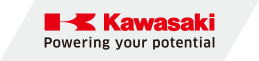


December 8, 2021 Medical Corporation TOMOHIROKAI Kawasaki Heavy Industries, Ltd. Kawasaki Links Up with TOMOHIROKAI to Expand PCR Test Center at Kansai International Airport New Clinic to Be Launched to Provide COVID-19 Testing and Certificates of Negative Result December 8, 2021 Kawasaki Heavy Industries, Ltd. announced their partnership with Medical Corporation TOMOHIROKAI to expand the capability of the PCR Test Center launched in September 2021 at Kansai International Airport (KIX). Artist s rendition of the new clinic (conceptual drawing) Artist s rendition of the PCR Test Center s reception counter TOMOHIROKAI will open the Kansai International Airport PCR Test Clinic, Medical Corporation TOMOHIROKAI on the fourth floor of Terminal 1 (International Departure Floor), beginning December 13, 2021, to offer pre-departure COVID-19 testing for international travelers. In addition to PCR tests, the clinic will provide quantitative antigen tests and serum IgM antibody tests to accommoda

In [6]:
#see data
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    urllib.request.urlretrieve(temp_df.iloc[iloc_no]['thumbnail'], "temp.jpg")
    display(Image.open("temp.jpg"))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [7]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [8]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        try:
            os.remove("temp.pdf")
        except:
            pass
        os.remove("temp.jpg")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

Trash removed successfully
